In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

In [3]:
nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [4]:
df_range = pd.read_csv('saprc99_range.csv', index_col=0)
df_range.head(10)

,min,max
H2SO4,2.131631e+10,1.223799e+12
HCOOH,1.941420e+10,1.137429e+11
CCO_OH,2.994973e+10,2.073705e+12
RCO_OH,1.275993e+10,1.380322e+12
CCO_OOH,8.695723e+05,1.215977e+12
RCO_OOH,4.160388e+05,7.387218e+11
XN,5.950410e+07,2.010207e+11
XC,4.906034e+12,5.593960e+12
SO2,8.404868e+05,1.202484e+12
O1D,1.000000e-08,7.012137e-01


# Make training data

In [5]:
y0_list = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(20000, 75) )
y0_list.shape

(20000, 75)

In [6]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 20.3 s, sys: 8 ms, total: 20.3 s
Wall time: 20.2 s


(20000, 74)

# Normalize data

In [7]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(20000, 75)

In [9]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([1.0004189 , 1.00349399, 1.00004007, 0.99996585, 1.00001314,
       1.00003208, 1.08422167, 1.06442623, 0.98013094, 0.95769208,
       0.99450769, 1.04519579, 0.89460802, 0.93668012, 0.97065943,
       1.42034709, 0.95627739, 9.22570584, 0.43827163, 0.9784098 ,
       0.95436112, 0.94327198, 0.85915386, 0.72226658, 0.92960173,
       0.89354164, 0.88599583, 5.84428003, 0.98078858, 0.9214043 ,
       0.8928935 , 0.87097241, 1.16284602, 0.28579552, 0.65999823,
       1.04899023, 0.83229378, 0.76339977, 0.36869311, 0.99917503,
       0.76184139, 0.99860894, 1.01410508, 0.83648488, 0.76423447,
       1.18345847, 0.25599085, 0.72368446, 0.09785992, 0.67302849,
       0.58000597, 0.54126898, 0.17445571, 0.86266395, 0.78460455,
       0.77984472, 0.93812916, 0.78503003, 0.75906539, 0.97610618,
       0.86044302, 0.94544757, 0.79959492, 0.84342597, 1.51081651,
       0.36970952, 0.56827459, 0.5701395 , 0.16016232, 1.05262485,
       0.38084092, 0.33378382, 0.23442432, 0.18039287])

# Fit ANN

In [10]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor).cuda())
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor).cuda())

In [11]:
H1, H2 = 300, 300

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
).cuda()

In [12]:
%%time
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters())
#optimizer = torch.optim.Adam(model.parameters())

for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.item())

20 0.024706173688173294
40 0.01078019943088293
60 0.006952785886824131
80 0.005373554769903421
100 0.004471218679100275
120 0.00391241954639554
140 0.0034809524659067392
160 0.0031607167329639196
180 0.0029143313877284527
200 0.0027114604599773884
CPU times: user 2min 33s, sys: 28.7 s, total: 3min 1s
Wall time: 3min 1s


In [13]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.cpu().numpy()

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 8.49 ms


In [14]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9988322725338662

## Scale-back to original concentration

In [15]:
y_pred_numpy

array([[ 0.18465918,  0.6638106 ,  0.39399529, ..., -1.6544837 ,
        -1.627775  , -1.6860058 ],
       [-1.1584854 ,  1.7749556 ,  0.28958616, ..., -1.3502867 ,
        -1.4102067 , -1.2131581 ],
       [-1.4816625 , -0.8071209 , -0.844664  , ..., -1.0468352 ,
        -0.38235602, -1.6413317 ],
       ...,
       [ 1.5005838 , -0.00180949,  1.6909819 , ..., -1.6226728 ,
        -1.7453444 , -1.6848593 ],
       [-1.0526456 , -0.5852682 , -1.1978111 , ..., -1.5625441 ,
        -1.6332096 , -1.5313101 ],
       [ 1.4529189 , -1.5259503 ,  0.25303915, ..., -1.3558917 ,
        -1.5245187 , -1.4314883 ]], dtype=float32)

In [16]:
y_pred_origin = normalizer.inverse_transform(y_pred_numpy)

In [17]:
def error_norm(y, y_true):
    """L1 error norm"""
    abserr = (np.abs(y - y_true)).mean(axis=0)
    return abserr/y_true.mean(axis=0)

In [18]:
L1_train = error_norm(y_pred_origin, y1_list) # train error varies across species
L1_train.mean()

0.05026273697681441

# Test set

In [19]:
y0_test = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(5000, 75) )
y0_list.shape

(20000, 75)

In [20]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 5.23 s, sys: 16 ms, total: 5.25 s
Wall time: 5.06 s


In [21]:
X_test = np.append(normalizer.transform(y0_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [22]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor).cuda())
y_test_pred = model(X_torch_test).data.cpu().numpy()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 3.76 ms


In [23]:
r2_score(y_test_pred, Y_test, multioutput='variance_weighted')

0.9653480008323762

In [24]:
y2_test_pred_origin= normalizer.inverse_transform(y_test_pred)
y2_test_pred_origin.shape

(5000, 74)

In [25]:
L1_test = error_norm(y2_test_pred_origin, y1_test) # test error varies across species
L1_test.mean()

0.057471435728177964

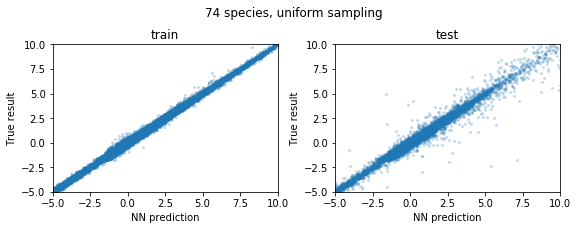

In [27]:
fig, axes = plt.subplots(1, 2, figsize=[8, 3])
axes[0].scatter(y_pred_numpy, Y_train, s=4, alpha=0.2)
axes[0].set_title('train')

axes[1].scatter(y_test_pred, Y_test, s=4, alpha=0.2)
axes[1].set_title('test')

def tweak_ax(ax):
    ax.set_xlim(-5, 10)
    ax.set_ylim(-5, 10)
    ax.set_xlabel('NN prediction')
    ax.set_ylabel('True result')
    
tweak_ax(axes[0])
tweak_ax(axes[1])

fig.suptitle('74 species, uniform sampling', y=1.05)
fig.tight_layout()
plt.savefig('saprc99_uniform_sampling.png', dpi=300)